<a href="https://colab.research.google.com/github/GurkiratSarna/CE888-Decision-Making-UoE/blob/master/Assignment_2/CE888_Assignment_2_Project_3_1900690.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt #plotting charts
import pandas as pd #helps importing datasets
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from math import *
import random
from google.colab import files
import io
import os
from google.colab import files

#Create Decision Tree classifier

create_DT_classifier() function takes as input the complete dataset of 2000 games and trains a Decision tree on it to return the classifier. 

The input data set is split into 70-30 percent for training and testing. A graph is plotted between accuracy and depth of the tree for 40 iterations. From this graph the depth of the tree which gives highest accuracy is used to train the classifiers for the complete project.

In [0]:
def create_DT_classifier(Data_in, get_depth, depth_max):
    #Split data into 70-30 percent for training and testing
    #print(len(Data_in))
    train_set, test_set = train_test_split(Data_in, test_size = 0.2, random_state=42)
    
    #Only take the features for training - 9 positions of the board and the player playing at the state
    Data_train_x=train_set.iloc[:,0:10]
    
    #the output column extracted from the data for training
    Data_train_y=train_set.iloc[:,-1]
    Data_train_y=Data_train_y.astype('int')
    
    #Only take the features for testin - 9 positions of the board and the player playing at the state
    Data_test_x=test_set.iloc[:,0:10]
    
    #the output column extracted from the data for testing
    Data_test_y=test_set.iloc[:,-1]
    Data_test_y=Data_test_y.astype('int')
    
    ########################
    #Plotting graph for accuracy against the depth of the decision tree ranging from 0 to 39 (inclusive)
    if(get_depth==1):
        #print("in if get_depth==1 : ", get_depth)
        depth_range = list(range(1,40))
        accuracy_list = []
        for depth in depth_range:
            classifier_DT1 = DecisionTreeClassifier(criterion='gini',max_depth=depth,random_state=42)
            classifier_DT1.fit(Data_train_x, Data_train_y)
            score = classifier_DT1.score(Data_test_x, Data_test_y)
            accuracy_list.append(score)
        plt.plot(depth_range,accuracy_list, label='Accuracy') # commented to save space for output
        plt.legend(framealpha=1, frameon=True)
        plt.xlabel('Depth')
        plt.ylabel('Accuracy')
        plt.show()  # commented to save space for output
        #Pick the depth at which accuracy is maximum only during the first run and train the classifier on that depth for the complete project.
        depth_max =(accuracy_list.index(max(accuracy_list)) + 1)
        print("maximum accuracy : ", max(accuracy_list))
        print("depth of decision tree is : ", depth_max)
    #########################'''
    
    #Train the classifier on the max accuracy in every iteration
    classifier_DT = DecisionTreeClassifier(criterion='gini',max_depth=depth_max,random_state=42)
    classifier_DT.fit(Data_train_x, Data_train_y)
    Pred_test_y=classifier_DT.predict(Data_test_x)
    #print(classification_report(Data_test_y,Pred_test_y)) #Need not print for Assignment 2 also commented to save space for output

    return classifier_DT, depth_max

#OXO Game
The OXO game creates a dataset of 100 games.

In [0]:
# This is a very simple implementation of the UCT Monte Carlo Tree Search algorithm in Python 2.7.
# The function UCT(rootstate, itermax, verbose = False) is towards the bottom of the code.
# It aims to have the clearest and simplest possible code, and for the sake of clarity, the code
# is orders of magnitude less efficient than it could be made, particularly by using a 
# state.GetRandomMove() or state.DoRandomRollout() function.
# 
# Example GameState classes for Nim, OXO and Othello are included to give some idea of how you
# can write your own GameState use UCT in your 2-player game. Change the game to be played in 
# the UCTPlayGame() function at the bottom of the code.
# 
# Written by Peter Cowling, Ed Powley, Daniel Whitehouse (University of York, UK) September 2012.
# 
# Licence is granted to freely use and distribute for any sensible/legal purpose so long as this comment
# remains in any distributed code.
# 
class OXOState:
    """ A state of the game, i.e. the game board.
        Squares in the board are in this arrangement
        012
        345
        678
        where 0 = empty, 1 = player 1 (X), 2 = player 2 (O)
    """
    def __init__(self):
        self.playerJustMoved = 2 # At the root pretend the player just moved is 2 whereas player 1 has the first move.
        self.board = [0,0,0,0,0,0,0,0,0] # 0 = empty, 1 = player 1, 2 = player 2. This is the initial board state - all positions are empty.
        
    def Clone(self):
        """ Create a deep clone of this game state.
        """
        st = OXOState()
        st.playerJustMoved = self.playerJustMoved
        st.board = self.board[:]
        return st

    def DoMove(self, move):
        """ Update the state board by replacing 0 with the player playing the move at the position/move of the board.
            Must update playerJustMoved.
        """
        assert move >= 0 and move <= 8 and move == int(move) and self.board[move] == 0
        self.playerJustMoved = 3 - self.playerJustMoved
        self.board[move] = self.playerJustMoved
        
    def GetMoves(self):
        """ Get all possible moves from this state. That is return all the positional values of the zroes in the state board.
        """
        return [i for i in range(9) if self.board[i] == 0]
    
    def GetResult(self, playerjm):
        """ Get the game result from the viewpoint of playerjm. 
        """
        for (x,y,z) in [(0,1,2),(3,4,5),(6,7,8),(0,3,6),(1,4,7),(2,5,8),(0,4,8),(2,4,6)]:
            #Winning possibilities of the board
            if self.board[x] == self.board[y] == self.board[z]: # check if values in all the 3 positions is of the same player
                # check if the player that just moved is same as the value in the winning positions, if yes return 1 else 0 stating that the other player wins.
                if self.board[x] == playerjm: 
                    return 1.0
                else:
                    return 0.0
        if self.GetMoves() == []:
          return 0.5 # draw
        return False # Should not be possible to get here

    def __repr__(self): # This is how the return value is defined for this class.
        s= ""
        for i in range(9): 
            s += ".XO"[self.board[i]] # . for 0, X for 1 and O for 2 positional values
            if i % 3 == 2: s += "\n"
        return s


class Node:
    """ A node in the game tree. Note : wins is always from the viewpoint of playerJustMoved.
        Crashes if state not specified.
    """
    def __init__(self, move = None, parent = None, state = None):
        self.move = move # the move that got us to this node - "None" for the root node
        #parentNode stores all the parents from the rootnode until the current node for backpropogation, during which it deletes until it is None.
        self.parentNode = parent # "None" for the root node.
        self.childNodes = []
        self.wins = 0
        self.visits = 0 #The number of itermax passed
        self.untriedMoves = state.GetMoves() # future child nodes. The available positions to be played at any point of the game.
        self.playerJustMoved = state.playerJustMoved # the only part of the state that the Node needs later
        
    def UCTSelectChild(self):
        """ Use the UCB1 formula to select a child node. Often a constant UCTK is applied so we have
            lambda c: c.wins/c.visits + UCTK * sqrt(2*log(self.visits)/c.visits to vary the amount of
            exploration versus exploitation.
        """
        s = sorted(self.childNodes, key = lambda c: c.wins/c.visits + sqrt(2*log(self.visits)/c.visits))[-1] #pick the highest
        return s
    
    def AddChild(self, m, s):
        """ Remove m from untriedMoves and add a new child node for this move.
            Return the added child node.
        """
        n = Node(move = m, parent = self, state = s)
        self.untriedMoves.remove(m)
        self.childNodes.append(n)
        return n
    
    def Update(self, result):
        """ Update this node - one additional visit and result additional wins. result must be from the viewpoint of playerJustmoved.
        """
        self.visits += 1
        self.wins += result

    def __repr__(self): # Added other variables to be returned to check the flow of the variable during testing small iterations.
        return "[M:" + str(self.move) + " W/V:" + str(self.wins) + "/" + str(self.visits) + " U:" + str(self.untriedMoves) + " PJM:" + str(self.playerJustMoved) + "]"

    def TreeToString(self, indent):
        s = self.IndentString(indent) + str(self)
        for c in self.childNodes:
             s += c.TreeToString(indent+1)
        return s

    def IndentString(self,indent):
        s = "\n"
        for i in range (1,indent+1):
            s += "| "
        return s

    def ChildrenToString(self):
        s = ""
        for c in self.childNodes:
             s += str(c) + "\n"
        return s

def GetRandomMove(s,c_dt):
    """We will pick a random value between 0.0 and 1.0. Considering there is a normal distribution between these values, 
       if we get a value between 0.0 and 0.9 then the decision tree classifier decides the next move on the given state otherwise a random integer is returned.
    """
    
    rand_num=random.uniform(0.0, 1.0)

    if rand_num <= 0.9:
        temp_list=list(s.board)
        temp_list.append(s.playerJustMoved)
        #print(temp_list)

        #print([s.board])
        next_move=c_dt.predict([temp_list])
        next_move=next_move[0]
    
        #If the move decided by decision tree classifier is not in the untried moves then we select randomly the next eligible move.
        if next_move not in s.GetMoves():
            next_move=random.choice(s.GetMoves())
            """Add the move taken at this state to a global list 'train_state'.
               These are unexepected states that will be combined with the dataset, containing 2000 game states, to train the model in next iteration.
            """
            st_board=list(s.board) #so that it does not point to the same memory address
            st_board.append(s.playerJustMoved)
            st_board.append(next_move) # append the random move at this state
            train_state.append(st_board)            
    else:
        next_move=random.choice(s.GetMoves())
    return next_move
    
def UCT(firstrun, classifier_dt, rootstate, itermax, verbose = False):
    """ Conduct a UCT search for itermax iterations starting from rootstate.
        Return the best move from the rootstate.
        Assumes 2 alternating players (player 1 starts), with game results in the range [0.0, 1.0]."""

    rootnode = Node(state = rootstate)

    for i in range(itermax):
        node = rootnode
        state = rootstate.Clone()

        # Select
        while node.untriedMoves == [] and node.childNodes != []: # node is fully expanded and non-terminal
            node = node.UCTSelectChild()
            state.DoMove(node.move)

        # Expand
        if node.untriedMoves != []:  # if we can expand (i.e. state/node is non-terminal)
            m = random.choice(node.untriedMoves) 
            state.DoMove(m)
            node = node.AddChild(m, state)  # add child and descend tree. This updates the parent node as well.

        # Rollout
        '''Game is played considering all eligible moves after the move chosen in Expand step.
        In every step of this game, a child node and parent node is added to form a tree. Once all possible branches are created the best move is returned
        using the UCB1 formula in UCTSelectChild() function.'''
        while state.GetMoves() != []: # while state is non-terminal
            if firstrun==1: # if the code is executed from the scratch and no initial input file of states is given.
                r=random.choice(state.GetMoves())
            else:
                r=GetRandomMove(state, classifier_dt)
            state.DoMove(r)
        
        # Backpropagate
        while node != None: # backpropagate from the expanded node and work back to the root node
            gr=state.GetResult(node.playerJustMoved)
            node.Update(gr) # state is terminal. Update node with result from POV of node.playerJustMoved
            node = node.parentNode

    # Output some information about the tree - Commented to save space for the output
    #if verbose: print(rootnode.TreeToString(0))
    #else: print(rootnode.ChildrenToString())
    
    ret=sorted(rootnode.childNodes, key = lambda c: c.visits)[-1].move

    return ret # return the move that was most visited as the best move.
                
def UCTPlayGame(firstrun, classifier_dt): #These simulations are MCTS
    """ Play a sample game between two UCT players where each player gets a different number 
        of UCT iterations (= simulations = tree nodes).
    """
    state = OXOState()
  
    tempdataset=[[0,0,0,0,0,0,0,0,0]] #  A temporary datset which will accumulate all the stages of one game
    # A list of best moves for that particular game. This will always have length of tempdataset-1 because of the initial stage in the temporary dataset.
    bestmovelist=[] #
    pjm_list=[] #List of player moving at the current board
    while state.GetMoves() != []:
        #print(str(state)) # prints the board. Commented to save the space for output visibility.
        
        '''We introduce bias towards player 1 because we associate player 1 to the most learnt Decision Tree (later).
        The bias is introduced by increasing the itermax value in 'else' as compared to itermax value in 'if' for player 2'''
        '''For assignment 2, we remove the bias to have a fair play between both the players and to ralise the learning'''
        '''1000:2000 -> No one wins; 1500:2000 -> No one wins; 10:1000 -> nearly 2.5% winning - Assignment 1
        10:1000 -> with 5000 iterations of UCTPlaygame -> 12.5% winning games - Assignment 1'''
        if state.playerJustMoved == 1: #The consition checks for player 1 but the best move is returned for player 2.
            m = UCT(firstrun, classifier_dt, rootstate=state, itermax=10, verbose=False)  # play with values for itermax and verbose = True.
        else:
            m = UCT(firstrun, classifier_dt, rootstate=state, itermax=10, verbose=False) # itermax decides the total value of visits to one node in a given game.
        #print("Best Move: " + str(m) + "\n") # Commented to save space for the output
        state.DoMove(m)
        
        pjm_list.append(state.playerJustMoved)
        bestmovelist.append(m)
        tempdataset.append(list(state.board))
        
        if state.GetResult(state.playerJustMoved) != False:
            #print(str(state)) # Commented to save space for the output
            break
    
    if state.GetResult(state.playerJustMoved) == 1.0:
        #print("Player " + str(state.playerJustMoved) + " wins!") #Commented to save space for the output
        winner=state.playerJustMoved
    elif state.GetResult(state.playerJustMoved) == 0.0:
        #print("Player " + str(3 - state.playerJustMoved) + " wins!") #Commented to save space for the output
        winner=(3-state.playerJustMoved)
    else: 
      #print("Nobody wins!") #Commented to save space for the output
      winner=0

    ''' This lists will always have one element less compared to tempdataset because the last state of the game will never have any move or player
    associated to it.
    Because we are combining the three lists so we want them of equal length hence the move and player at the last stage will be NaN, 
    The last game state will be removed later from the final dataframe.'''
    bestmovelist.append('NaN')
    pjm_list.append('NaN')

    for i in range(len(tempdataset)): 
      tempdataset[i].append(pjm_list[i]) #Append the Player at the board state
      tempdataset[i].append(bestmovelist[i]) # Append the move taken at every stage.

    return tempdataset, winner 

def create_OXO_dataset(num_games, firstrun, classifier_dt):
    """ Play a single game to the end using UCT for both players. 
    """
    finaldataset=[] # A list of lists of the game stages. Each list is one game, representing the lists of stages returned.
    finaldataset1=[] # A list of all the stages of the games in the finaldataset. It is the output of converting a list of list into one list.
    
    p1win=0
    p2win=0
    Nowin=0
    winner=0
    for i in range(num_games): # Run the UCTPlayGame 2000 times.
      returnds, winner =UCTPlayGame(firstrun, classifier_dt) # returnds stores the game temporarily.
      finaldataset.append(returnds) 
      if winner==1:
        p1win+=1
      elif winner==2:
        p2win+=1
      else:
        Nowin+=1

    #Convert list of lists to one list
    for i in finaldataset:  
      for j in i:  
        finaldataset1.append(j) 

    #Name the columns of the finaldataset1 and convert it into a dataframe.
    datatbp=pd.DataFrame(finaldataset1, columns=['0th pos', '1st pos', '2nd pos', '3rd pos', '4th pos', '5th pos', '6th pos', '7th pos', '8th pos', 'Player', 'Move'])
     
    #Remove the rows that have 'NaN' as these are the rows depicting the last stage of the game with no move.
    datatbp.drop(datatbp[datatbp.Move == 'NaN'].index, inplace=True)
    datatbp.reset_index(drop=True, inplace=True) #  Reset the row index of the data frame

    #print("Wins : Player1 : ", p1win, " Player2 : ", p2win, " Nobody wins : ", Nowin) #Commented to save space for the output
    
    return datatbp

#Classifiers collection
create_classifier_dict() function creates the dictionary of classifiers for each datset of 2000 games played. The num_classifier is a value for the number of classifiers (number of datsets of 2000 games each) needed in a dictionary in one iteration.

In [0]:
def create_classifier_dict(num_datasets, num_of_games, first_file, Data_user):
   
   get_depth=1
   depth_max=0
   dict_classifier=dict()
   classifier=None
   
   """firstrun is a flag depicting if the code is going to create a dataset of 2000 games for the first time or not. 
      1 means it is a first run and 0 means it is not.
   """
   if (first_file==1):
       classifier, depth_max =create_DT_classifier(Data_user, get_depth, depth_max)
       #print('depth_max : ', depth_max)
       dict_classifier[int('0')]=classifier
       #print(dict_classifier)
       num_datasets=num_datasets-1
       firstrun=0
       get_depth=0
   else:
       firstrun=1
    
   for i in range(num_datasets):
       #print('Value of i : ', i)
       data_tbp=create_OXO_dataset(num_of_games, firstrun, classifier) # Is this imitation learning that includes the apprentice policy and expert policy creation ?
       print(train_state)
       comb_train_state=pd.DataFrame(train_state,columns=['0th pos', '1st pos', '2nd pos', '3rd pos', '4th pos', '5th pos', '6th pos', '7th pos', '8th pos', 'Player','Move'])
       data_tbp=pd.concat([data_tbp,comb_train_state],ignore_index=True, axis=0)
       if(firstrun==1):
           data_tbp.to_csv('CE888_DataToBeProcessed_1900690.csv')
           files.download('CE888_DataToBeProcessed_1900690.csv') 
       #combine the data_tbp and train_state here and then create a classifier
       classifier, depth_max =create_DT_classifier(data_tbp, get_depth, depth_max)
       #print('depth_max : ', depth_max)
       
       if(first_file==1):
           dict_classifier.update({i+1:classifier})
       else:
           dict_classifier.update({i:classifier})
       
       firstrun=0
       get_depth=0
       train_state.clear()
   return dict_classifier

#OXO Game for Classifiers
Below is a modified version of OXO game to have the classifiers play against each other. The class Node and OXOstate have not been redefined. We associate player 1 with every 10th classifier and player 2 with it's previous 9 versions of the classifier. That is tenth DT classifier (DT10) will play against first DT classifier (DT1) then with DT2 and so on until DT9. After every iteration we calculate the number of times DT10 wins against DT1, DT2...DT9. Player 1 always plays with DT10 decisions and player 2 plays with DT1, DT2...DT9 decisions.

In [0]:
def GetRandomMove1(DTclassifier, s):
    temp_list=list(s.board)
    temp_list.append(s.playerJustMoved)
    print(temp_list)
    print(s.board)
    r=DTclassifier.predict([temp_list])
    r=r[0]
    if r not in s.GetMoves():
        r=random.choice(s.GetMoves())
    return r

def UCT1(pl1_classifier, pl2_classifier,rootstate, itermax, verbose = False):
    """ Conduct a UCT search for itermax iterations starting from rootstate.
        Return the best move from the rootstate.
        Assumes 2 alternating players (player 1 starts), with game results in the range [0.0, 1.0]."""

    rootnode = Node(state = rootstate)

    for i in range(itermax):
        node = rootnode
        state = rootstate.Clone()

        # Select
        while node.untriedMoves == [] and node.childNodes != []: # node is fully expanded and non-terminal
            node = node.UCTSelectChild()
            state.DoMove(node.move)

        # Expand
        if node.untriedMoves != []: # if we can expand (i.e. state/node is non-terminal)            
            m = random.choice(node.untriedMoves)
            state.DoMove(m)
            node = node.AddChild(m,state) # add child and descend tree

        # Rollout 
        while state.GetMoves() != []: # while state is non-terminal

            if(state.playerJustMoved==1):
                r=GetRandomMove1(pl1_classifier,state)
            else:
                r=GetRandomMove1(pl2_classifier,state)
            state.DoMove(r)

        # Backpropagate
        while node != None: # backpropagate from the expanded node and work back to the root node
            node.Update(state.GetResult(node.playerJustMoved)) # state is terminal. Update node with result from POV of node.playerJustMoved
            node = node.parentNode

    # Output some information about the tree - Commented to save space for Output
    #if (verbose): print(rootnode.TreeToString(0))
    #else: print(rootnode.ChildrenToString())

    return sorted(rootnode.childNodes, key = lambda c: c.visits)[-1].move # return the move that was most visited
                
def UCTPlayGame1(pl1_classifier, pl2_classifier):
    """ Play a sample game between two UCT players where each player gets a different number 
        of UCT iterations (= simulations = tree nodes).
    """
    
    state = OXOState() 
    
    while (state.GetMoves() != []):
        #print(str(state)) #Commented to save space for Output
        if state.playerJustMoved == 1:
            m = UCT1(pl1_classifier, pl2_classifier,rootstate = state, itermax = 10, verbose = False) 
        else:
            m = UCT1(pl1_classifier, pl2_classifier, rootstate = state, itermax =10, verbose = False)
        #print("Best Move: " + str(m) + "\n") #Commented to save space for Output
        state.DoMove(m)
        if state.GetResult(state.playerJustMoved) != False:
            #print(str(state)) #Commented to save space for Output
            break
    if state.GetResult(state.playerJustMoved) == 1.0:
        #print("Player " + str(state.playerJustMoved) + " wins!") #Commented to save space for Output
        return state.playerJustMoved
    elif state.GetResult(state.playerJustMoved) == 0.0:
        #print("Player " + str(3 - state.playerJustMoved) + " wins!") #Commented to save space for Output
        return (3-state.playerJustMoved)
    else:
        #print("Nobody wins!") #Commented to save space for Output
        return 0

#Classifier Game Play
Gameplay_classifiers() function calls the create_classifier_dict() to get a dictionary of classifiers trained on a single dataset of 2000 games. After a single dictionary is received, OXO Game is played between the classifiers by calling UCTPlayGame1() function. The UCTPlayGame1() function is provided with 2 classifers, the first classifier is always the tenth classifier and the second classifier varies from DT1 until DT9.

Please enter the number of games to be played : 10
Please enter the number of datasets required to be created. Each dataset is a collection of states of a number of OXO games : 10
Will you provide the initial datset (Yes=1;No=0) : 0
[]


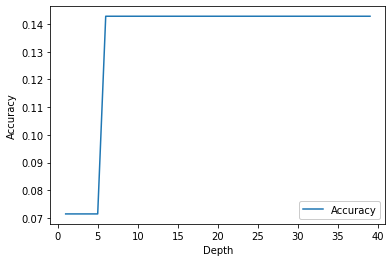

Streaming output truncated to the last 5000 lines.
[0, 0, 2, 1, 0, 1, 1, 0, 2]
[0, 0, 2, 1, 0, 1, 1, 2, 2, 2]
[0, 0, 2, 1, 0, 1, 1, 2, 2]
[1, 0, 2, 1, 0, 1, 1, 2, 2, 1]
[1, 0, 2, 1, 0, 1, 1, 2, 2]
[1, 2, 2, 1, 0, 1, 1, 2, 2, 2]
[1, 2, 2, 1, 0, 1, 1, 2, 2]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 2, 0, 0, 0, 0, 2]
[1, 0, 0, 0, 2, 0, 0, 0, 0]
[1, 0, 1, 0, 2, 0, 0, 0, 0, 1]
[1, 0, 1, 0, 2, 0, 0, 0, 0]
[1, 2, 1, 0, 2, 0, 0, 0, 0, 2]
[1, 2, 1, 0, 2, 0, 0, 0, 0]
[1, 2, 1, 1, 2, 0, 0, 0, 0, 1]
[1, 2, 1, 1, 2, 0, 0, 0, 0]
[1, 2, 1, 1, 2, 0, 2, 0, 0, 2]
[1, 2, 1, 1, 2, 0, 2, 0, 0]
[1, 2, 1, 1, 2, 0, 2, 0, 1, 1]
[1, 2, 1, 1, 2, 0, 2, 0, 1]
[1, 2, 1, 1, 2, 2, 2, 0, 1, 2]
[1, 2, 1, 1, 2, 2, 2, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 2, 0, 1, 2]
[0, 0, 0, 0, 0, 0, 2, 0, 1]
[0, 0, 1, 0, 0, 0, 2, 0, 1, 1]
[0, 0, 1, 0, 0, 0, 2, 0, 1]
[0, 0, 1, 0, 0, 0, 2, 2, 1, 2]
[0, 0, 1, 0, 0, 0, 2, 2, 1]
[0, 0, 1, 1, 0, 0, 2, 2, 1, 1]
[0, 0

In [0]:
if __name__ == "__main__":
 
  # create a global list to record the unexpected states encountered by the Decision tree. These are states for which DT could not give an eligible move.
   
  global train_state
  train_state=[]
  
  no_of_games=int(input("Please enter the number of games to be played to create a single data set of states: "))
  no_of_clsfr=int(input('Please enter the number of datasets required to be created (multiple of 10). Each dataset is a collection of states of a number of OXO games : '))
  first_file=int(input("Will you provide the initial datset (Yes=1;No=0) : "))


  if(first_file==1):
    uploaded = files.upload()
    fname=input('Enter csv file name with extention and no path : ')
    Data_user = pd.read_csv(io.BytesIO(uploaded[fname]))
  else:
    Data_user = 0
  
  dict_clfr=create_classifier_dict(no_of_clsfr, no_of_games, first_file, Data_user)
  #print('Length of dictionary : ', len(dict_clfr))
  #print('dictionary : ', dict_clfr)
  
  for i in range(0,len(dict_clfr),10):
      DT10=0
      DTother=0
      Nowin=0
      j=i
      for j in range(i, i+9): # execute from 0 until 8th index of every tenth position
          winner = UCTPlayGame1(dict_clfr[9+10*(i//10)], dict_clfr[j]) # transfer 9 always and every value from 0 to 8
          #print(winner)
          if winner==1:
            #print('DT10 wins')
            DT10+=1
          elif winner==2:
            #print('DT',i+1,' wins')
            DTother+=1
          else:
            #print('No wins')
            Nowin+=1
      print("Wins : \n DT10 : ", DT10, " Other DTs : ", DTother, " No wins : ", Nowin)

In [0]:
#100:100, 300 games, 200 datsets - no file given
'''maximum accuracy :  0.603448275862069
depth of decision tree is :  13
Wins : 
 DT10 :  3  Other DTs :  1  No wins :  5
Wins : 
 DT10 :  5  Other DTs :  0  No wins :  4
Wins : 
 DT10 :  3  Other DTs :  0  No wins :  6
Wins : 
 DT10 :  7  Other DTs :  0  No wins :  2
Wins : 
 DT10 :  6  Other DTs :  0  No wins :  3
Wins : 
 DT10 :  1  Other DTs :  2  No wins :  6
Wins : 
 DT10 :  6  Other DTs :  1  No wins :  2
Wins : 
 DT10 :  3  Other DTs :  0  No wins :  6
Wins : 
 DT10 :  4  Other DTs :  0  No wins :  5
Wins : 
 DT10 :  7  Other DTs :  1  No wins :  1
Wins : 
 DT10 :  4  Other DTs :  3  No wins :  2
Wins : 
 DT10 :  6  Other DTs :  0  No wins :  3
Wins : 
 DT10 :  4  Other DTs :  1  No wins :  4
Wins : 
 DT10 :  4  Other DTs :  1  No wins :  4
Wins : 
 DT10 :  4  Other DTs :  0  No wins :  5
Wins : 
 DT10 :  3  Other DTs :  1  No wins :  5
Wins : 
 DT10 :  6  Other DTs :  0  No wins :  3
Wins : 
 DT10 :  4  Other DTs :  3  No wins :  2
Wins : 
 DT10 :  6  Other DTs :  1  No wins :  2
Wins : 
 DT10 :  5  Other DTs :  3  No wins :  1'''

In [0]:
#100:100, 100 games, 50 datsets
'''maximum accuracy :  0.7266803840877915
depth of decision tree is :  11
Wins : 
 DT10 :  5  Other DTs :  0  No wins :  4
Wins : 
 DT10 :  7  Other DTs :  0  No wins :  2
Wins : 
 DT10 :  6  Other DTs :  2  No wins :  1
Wins : 
 DT10 :  2  Other DTs :  1  No wins :  6
Wins : 
 DT10 :  3  Other DTs :  0  No wins :  6'''

'maximum accuracy :  0.7266803840877915\ndepth of decision tree is :  11\nWins : \n DT10 :  5  Other DTs :  0  No wins :  4\nWins : \n DT10 :  7  Other DTs :  0  No wins :  2\nWins : \n DT10 :  6  Other DTs :  2  No wins :  1\nWins : \n DT10 :  2  Other DTs :  1  No wins :  6\nWins : \n DT10 :  3  Other DTs :  0  No wins :  6'

In [0]:
#100:100, 300 games, 10 runs 100 datasets
'''Please enter the number of games to be played : 100
Please enter the number of datasets required to be created. Each dataset is a collection of states of a number of OXO games : 100
Will you provide the initial datset (Yes=1;No=0) : 1

CE888_DataToBeProcessed_1900690_6261Wins.csv(application/vnd.ms-excel) - 1126208 bytes, last modified: 4/12/2020 - 100% done
Saving CE888_DataToBeProcessed_1900690_6261Wins.csv to CE888_DataToBeProcessed_1900690_6261Wins (1).csv
Enter file name with extention and np path : CE888_DataToBeProcessed_1900690_6261Wins.csv

maximum accuracy :  0.7266803840877915
depth of decision tree is :  11
Wins : 
 DT10 :  4  Other DTs :  0  No wins :  5
Wins : 
 DT10 :  6  Other DTs :  0  No wins :  3
Wins : 
 DT10 :  5  Other DTs :  0  No wins :  4
Wins : 
 DT10 :  7  Other DTs :  0  No wins :  2
Wins : 
 DT10 :  5  Other DTs :  1  No wins :  3
Wins : 
 DT10 :  3  Other DTs :  0  No wins :  6
Wins : 
 DT10 :  2  Other DTs :  1  No wins :  6
Wins : 
 DT10 :  5  Other DTs :  0  No wins :  4
Wins : 
 DT10 :  3  Other DTs :  0  No wins :  6
Wins : 
 DT10 :  4  Other DTs :  0  No wins :  5'''

'Please enter the number of games to be played : 100\nPlease enter the number of datasets required to be created. Each dataset is a collection of states of a number of OXO games : 100\nWill you provide the initial datset (Yes=1;No=0) : 1\n\nCE888_DataToBeProcessed_1900690_6261Wins.csv(application/vnd.ms-excel) - 1126208 bytes, last modified: 4/12/2020 - 100% done\nSaving CE888_DataToBeProcessed_1900690_6261Wins.csv to CE888_DataToBeProcessed_1900690_6261Wins (1).csv\nEnter file name with extention and np path : CE888_DataToBeProcessed_1900690_6261Wins.csv\n\nmaximum accuracy :  0.7266803840877915\ndepth of decision tree is :  11\nWins : \n DT10 :  4  Other DTs :  0  No wins :  5\nWins : \n DT10 :  6  Other DTs :  0  No wins :  3\nWins : \n DT10 :  5  Other DTs :  0  No wins :  4\nWins : \n DT10 :  7  Other DTs :  0  No wins :  2\nWins : \n DT10 :  5  Other DTs :  1  No wins :  3\nWins : \n DT10 :  3  Other DTs :  0  No wins :  6\nWins : \n DT10 :  2  Other DTs :  1  No wins :  6\nWins 

In [0]:
#50 games,
'''Please enter the number of games to be played : 50
Please enter the number of datasets required to be created. Each dataset is a collection of states of a number of OXO games : 100
Length of dictionary :  100
Wins : 
 DT10 :  7  Other DTs :  1  No wins :  1
Wins : 
 DT10 :  7  Other DTs :  1  No wins :  1
Wins : 
 DT10 :  3  Other DTs :  3  No wins :  3
Wins : 
 DT10 :  7  Other DTs :  2  No wins :  0
Wins : 
 DT10 :  5  Other DTs :  2  No wins :  2
Wins : 
 DT10 :  3  Other DTs :  5  No wins :  1
Wins : 
 DT10 :  8  Other DTs :  0  No wins :  1
Wins : 
 DT10 :  3  Other DTs :  4  No wins :  2
Wins : 
 DT10 :  4  Other DTs :  2  No wins :  3
Wins : 
 DT10 :  6  Other DTs :  1  No wins :  2'''

In [0]:
#50:50,50:50, 1000 games, 10, 10 - same DT classifier depth for every 10 iterations.

In [0]:
#100;10, 50:50, 200 games, 10,10
'''Please enter the number of games to be played between Decision tree Classifiers : 10
Please enter the number of decision tree classifiers required for each iteration : 10
Wins : 
 DT10 :  6  Other DTs :  2  No wins :  1
Wins : 
 DT10 :  3  Other DTs :  3  No wins :  3
Wins : 
 DT10 :  4  Other DTs :  0  No wins :  5
Wins : 
 DT10 :  5  Other DTs :  0  No wins :  4
Wins : 
 DT10 :  6  Other DTs :  1  No wins :  2
Wins : 
 DT10 :  4  Other DTs :  1  No wins :  4
Wins : 
 DT10 :  5  Other DTs :  1  No wins :  3
Wins : 
 DT10 :  4  Other DTs :  0  No wins :  5
Wins : 
 DT10 :  3  Other DTs :  1  No wins :  5
Wins : 
 DT10 :  3  Other DTs :  2  No wins :  4'''

In [0]:
#100:10, 10:90,200 games, 10,10 
'''Please enter the number of games to be played between Decision tree Classifiers : 10
Please enter the number of decision tree classifiers required for each iteration : 10
Wins : 
 DT10 :  7  Other DTs :  2  No wins :  0
Wins : 
 DT10 :  6  Other DTs :  2  No wins :  1
Wins : 
 DT10 :  6  Other DTs :  2  No wins :  1
Wins : 
 DT10 :  6  Other DTs :  1  No wins :  2
Wins : 
 DT10 :  8  Other DTs :  0  No wins :  1
Wins : 
 DT10 :  6  Other DTs :  1  No wins :  2
Wins : 
 DT10 :  8  Other DTs :  0  No wins :  1
Wins : 
 DT10 :  4  Other DTs :  1  No wins :  4
Wins : 
 DT10 :  8  Other DTs :  0  No wins :  1
Wins : 
 DT10 :  8  Other DTs :  0  No wins :  1'''

In [0]:
#50:50,10:90 200 games, 10,10
'''Please enter the number of games to be played between Decision tree Classifiers : 10
Please enter the number of decision tree classifiers required for each iteration : 10
Wins : 
 DT10 :  7  Other DTs :  1  No wins :  1
Wins : 
 DT10 :  7  Other DTs :  2  No wins :  0
Wins : 
 DT10 :  8  Other DTs :  1  No wins :  0
Wins : 
 DT10 :  8  Other DTs :  0  No wins :  1
Wins : 
 DT10 :  5  Other DTs :  1  No wins :  3
Wins : 
 DT10 :  8  Other DTs :  0  No wins :  1
Wins : 
 DT10 :  7  Other DTs :  1  No wins :  1
Wins : 
 DT10 :  7  Other DTs :  2  No wins :  0
Wins : 
 DT10 :  6  Other DTs :  3  No wins :  0
Wins : 
 DT10 :  5  Other DTs :  0  No wins :  4'''

In [0]:
#10:20,500,10,10
'''Please enter the number of games to be played between Decision tree Classifiers : 10
Please enter the number of decision tree classifiers required for each iteration : 10
Wins : 
 DT10 :  6  Other DTs :  1  No wins :  2
Wins : 
 DT10 :  4  Other DTs :  1  No wins :  4
Wins : 
 DT10 :  5  Other DTs :  2  No wins :  2
Wins : 
 DT10 :  6  Other DTs :  1  No wins :  2
Wins : 
 DT10 :  8  Other DTs :  0  No wins :  1
Wins : 
 DT10 :  4  Other DTs :  3  No wins :  2
Wins : 
 DT10 :  5  Other DTs :  2  No wins :  2
Wins : 
 DT10 :  3  Other DTs :  4  No wins :  2
Wins : 
 DT10 :  7  Other DTs :  1  No wins :  1
Wins : 
 DT10 :  7  Other DTs :  0  No wins :  2'''

In [0]:
#5:500, 2000, 10,10
'''Please enter the number of games to be played between Decision tree Classifiers : 10
Please enter the number of decision tree classifiers required for each iteration : 10
Wins : 
 DT10 :  7  Other DTs :  2  No wins :  0
Wins : 
 DT10 :  9  Other DTs :  0  No wins :  0
Wins : 
 DT10 :  8  Other DTs :  1  No wins :  0
Wins : 
 DT10 :  9  Other DTs :  0  No wins :  0
Wins : 
 DT10 :  4  Other DTs :  3  No wins :  2'''

In [0]:
''' 10: 1000 ; 2000 runs.
Wins : 
 DT10 :  9  Other DTs :  0  No wins :  0
Wins : 
 DT10 :  7  Other DTs :  2  No wins :  0
Wins : 
 DT10 :  8  Other DTs :  1  No wins :  0
Wins : 
 DT10 :  8  Other DTs :  0  No wins :  1
Wins : 
 DT10 :  8  Other DTs :  1  No wins :  0
Wins : 
 DT10 :  7  Other DTs :  2  No wins :  0
Wins : 
 DT10 :  6  Other DTs :  3  No wins :  0
Wins : 
 DT10 :  7  Other DTs :  2  No wins :  0
 '''

In [0]:
#Download the Dataset to be processed in Assignment 2
#2000*10= 20000; 20000-2000=18000 rows if nobody wins for all games.
#from google.colab import files
#datatbp.to_csv('CE888_DataToBeProcessed_1900690.csv')
#files.download('CE888_DataToBeProcessed_1900690.csv')

In [0]:
'''import os
print(os.getcwd())'''

In [0]:
'''#Get data set from Drive
Data=pd.read_csv('CE888_DataToBeProcessed_1900690_6261Wins.csv')
Data'''